# Advanced Topics in Distributed System (CE7490)

### Implementing algorithms discussed in Least Cost Rumor Blocking in Social Networks
#### By Lidan Fan*, Zaixin Lu*, Weili Wu*, Bhavani Thuraisingham*, Huan Ma†, and Yuanjun Bi

Done by: Amarildo Alberto Come, Elise Auvray, and Remi Boukheloua

In [1]:
#pip install python-louvain. If pip not found / working, use conda install pip
import community as cmy
import networkx as nx

from collections import defaultdict

import numpy as np
import random

import operator

# Set up of the simulation

In [2]:
#Dataset to use Enron email or Hep
datasetToUse = "Enron" #Enron or Hep

#Approximate size of the community we want to have rumor spread from
#We will pick the community with the closest size if we don't find it exactly
wantedSize = 2600
#%age of nodes in the community that will spread rumors
rumorProportion = 0.05


### Structure of our network (Graph):

In [3]:
class Graph: 

	# Constructor 
	def __init__(self): 
		# default dictionary to store graph 
		self.graph = defaultdict(list) 
		#to count number of nodes
		self.control=set()
	# function to add an edge to graph 
	def addEdge(self,u,v):
		#just for testing...should be removed...nodes will be counted from file
		if u not in self.control:
			self.control.add(u)
		if v not in self.control:
			self.control.add(v)
		self.graph[u].append(v) 

### To find Bridge Ends

In [4]:
def BFS(graph, s,community):
    edge_ends=[] #our desired output
    visited=[]
    #number of nodes should not be fixed
    visited = dict()
    
    for i in g.control:
        visited[i] = False
    
    #Number of nodes in grapth
    #print(len(graph.control))
    #get the graph per si
    graph=graph.graph
    # Create a queue for BFS 
    queue = [] 

    # Mark the source node as 
    # visited and enqueue it 
    for i in s:
        queue.append(i) 
        visited[i] = True

    while queue: 

        # Dequeue a vertex from queue
        s = queue.pop(0) 

        # Get all adjacent vertices of the 
        # dequeued vertex s. If a adjacent is from the community 
        # and has not been visited, then mark it 
        # visited and enqueue it otherwise just mark it as visited and add to edges vetor
        for i in graph[s]:
            if i in community:
                if visited[i] == False:
                    queue.append(i) 
                    visited[i] = True
            else:
                if visited[i] == False:
                    visited[i] = True
                    edge_ends.append(i)
    return edge_ends


#basic function to find all paths between 2 nodes	
def find_all_paths(graph, start, end, path=[]):
    path = path + [start]
    if start == end:
        return [path]
    if start not in graph:
        return []
    paths = []
    for node in graph[start]:
        if node not in path:
            newpaths = find_all_paths(graph, node, end, path)
            for newpath in newpaths:
                paths.append(newpath)
    return paths


### Import of data and Graph Creation

In [5]:
g = Graph() 
if datasetToUse == "Enron":
    emailEnron = np.loadtxt("Email-Enron.txt")
    for i in emailEnron:
        g.addEdge(int(i[0]),int(i[1]))
elif datasetToUse == "Hep":
    hepPh = np.loadtxt("CA-HepPh.txt") 
    for i in hepPh:
        g.addEdge(int(i[0]),int(i[1]))

### Finding communities using Louvain's Method

Using : [25] V. D. Blondel, J. Guillaume, R. Lambiotte and E. Lefebvre, Fast unfolding of communities in large networks. J. Stat.
Mech.: Theory and Experiment, 2008

In [6]:
def getLouvainCommunities(g): 
    G=nx.Graph(g.graph)
    communities = cmy.best_partition(G)
    c = [ [] for i in range(len(set(communities.values()))) ]
    for i in communities.keys():
        c[communities[i]].append(i)
    return c

In [7]:
#Getting communities set
community = getLouvainCommunities(g)

### Finding Bridge Ends

In [8]:
index = np.argmin([abs(len(community[i]) - wantedSize) for i in range(len(community))])

#here for simplicity i use only one rumor node (easy to fix)
Srumor=random.choices(community[index], k=int(rumorProportion * len(community[index])))

#run the customized BFS function on the graph

bridgeEnds = BFS(g, Srumor, community[index])

#print my output = the edge ends neighbour communities
#print (bridgeEnds)

#print the Paths from the rumor to each edge end
#for end in edge_ends:
	#paths=find_all_paths(g.graph,rumor,end)
	#print(end)

In [9]:
print("Community Size:", len(community[index]))
print("Percentage of the community in Sr:", rumorProportion, "which means", int(rumorProportion * len(community[index])), "persons")

Community Size: 2777
Percentage of the community in Sr: 0.05 which means 138 persons


### Backward Trees and finding the candidates to be protectors

In [10]:
def findParents(graph, node):
    listOfParents = []
    for i in graph.keys():
        if node in graph[i]:
            listOfParents.append(i)
    return listOfParents


In [11]:
def backwardTree(graph, bridgeEnd, rumors):
    tree = [[bridgeEnd]]
    visited = [bridgeEnd]
    findOneRumor = False
    while not findOneRumor:
        nbElement = len(tree)
        for i in range(nbElement):
            branch = tree.pop(0)
            listOfParents = findParents(g.graph, branch[-1])
            for parent in listOfParents:
                if parent not in visited:
                    tree.append(branch + [parent])
                    visited.append(parent)
                    findOneRumor = findOneRumor or (parent in rumors)
    return visited, tree

def protectorCandidateSets(tree, rumors):
    candidateSet = []
    for branch in tree:
        candidateSet += branch
    candidateSet = set(candidateSet).difference(set(rumors))
    return candidateSet
    

In [12]:
def backwardTree2(graph, bridgeEnd, rumors):
    fifoQ = [bridgeEnd]
    visited = [bridgeEnd]
    findOneRumor = False
    while not findOneRumor and len(fifoQ) != 0:
        branch = fifoQ.pop(0)
        listOfParents = findParents(g.graph, branch)
        for parent in listOfParents:
            if parent not in visited:
                fifoQ.append(parent)
                visited.append(parent)
                findOneRumor = findOneRumor or (parent in rumors)
    return visited

In [13]:
candidates = dict()
tmp = 0

for bridge in bridgeEnds:
    tmp += 1
    visited = backwardTree2(g.graph, bridge, Srumor)
    pCandidates = set(visited).difference(set(Srumor))
    #pCandidates = protectorCandidateSets(visited, Srumor)

    for i in pCandidates:
        if i not in candidates.keys():
            candidates[i] = []
        candidates[i].append(bridge)
    
    
    if tmp%int(len(bridgeEnds)/10 + 1) == 0:
        print(tmp/int(len(bridgeEnds)/10 + 1)*10, "% - Done")

print("100.0% - Done")

10.0 % - Done
20.0 % - Done
30.0 % - Done
40.0 % - Done
50.0 % - Done
60.0 % - Done
70.0 % - Done
80.0 % - Done
90.0 % - Done
100.0% - Done


### Picking protectors with Greedy Algorithm

In [14]:
Sp = []
PB = []

maxProtection = 0
while len(PB) != len(bridgeEnds):
    choosenCandidate = 0
    for i in candidates.keys():
        protection = len(set(PB + candidates[i]))
        if protection > maxProtection:
            maxProtection = protection
            choosenCandidate = i
    Sp.append(choosenCandidate)
    PB = list(set(PB + candidates[choosenCandidate]))
    candidates.pop(choosenCandidate)

### Others algorithms

#### MaxDegree

A basic algorithm, which simply chooses the nodes according to the decreasing order of node (out) degree as the protectors.

In [15]:
outDegree = dict()
for i in g.graph.keys():
    outDegree[i] = len(set(g.graph[i]))  #.intersection(bridgeEnds))
SpMaxDegree = []
PBMaxDegree = []
while len(PBMaxDegree) != len(bridgeEnds):
    newProtector = max(outDegree.items(), key=operator.itemgetter(1))[0]
    SpMaxDegree.append(newProtector)
    protectedBridges = set(g.graph[newProtector] + [newProtector]).intersection(bridgeEnds)
    PBMaxDegree = list(set(PBMaxDegree + list(protectedBridges)))
    #print(len(PBMaxDegree), newProtector, outDegree[newProtector])
    del outDegree[newProtector]

#### Proximity (WIP)
A simple heuristic algorithm, in which the direct out-neighbors of rumors are chosen as the protectors.
We exclude random algorithm due to its poor performance. Instead, a NoBlocking line is included to reflect the performance of these algorithms.

In [16]:
SpProximity = []
for r in Srumor:
    SpProximity += g.graph[r]

SpProximity = list(set(SpProximity))

### Results

In [17]:
print("Community Size:", len(community[index]))
print("Percentage of the community in Sr:", rumorProportion, "which means", int(rumorProportion * len(community[index])), "persons")
print("Nb of bridge ends:", len(bridgeEnds))

Community Size: 2777
Percentage of the community in Sr: 0.05 which means 138 persons
Nb of bridge ends: 2192


##### Greedy Algorithm:

In [18]:
print("Nb of candidates to be protectors:", len(candidates) + len(Sp))
print("Nb of protector recquired:", len(Sp))

Nb of candidates to be protectors: 28301
Nb of protector recquired: 36


##### MaxDegree

In [19]:
print("Nb of protector found:", len(SpMaxDegree))

Nb of protector found: 6988


##### Proximity

In [20]:
print("Nb of protector found:", len(SpProximity))

Nb of protector found: 1073


#### Curves

In [21]:
import matplotlib.pyplot as plt

In [22]:
def createCurve(nbProtector, setProtector, setRumor, graph):
    networkStatus = dict()
    toVisit = []
    visited = []

    Protectors = setProtector[:min(nbProtector, len(setProtector))]
    RumorOrigin = setRumor

    for i in Protectors:
        networkStatus[i] = ("P",1)
        toVisit.append(i)

    for i in RumorOrigin:
        networkStatus[i] = ("I",1)
        toVisit.append(i)

    while len(toVisit) != 0:
        i = toVisit.pop(0)
        visited.append(i)
        for direction in graph[i]:
            if direction not in visited:
                if direction in networkStatus.keys() and networkStatus[i][1] < networkStatus[direction][1]:
                    networkStatus[direction] = (max(networkStatus[i][0],networkStatus[direction][0]), networkStatus[i][1] + 1)
                elif direction not in networkStatus.keys(): 
                    networkStatus[direction] = (networkStatus[i][0], networkStatus[i][1]+1)
                if direction not in toVisit: toVisit.append(direction)

    maxHop = 0
    for i in networkStatus.keys():
        maxHop = max(maxHop, networkStatus[i][1])

    infectedPerHop = [0 for i in range(maxHop+1)]
    protectedPerHop = [0 for i in range(maxHop+1)]
    for i in networkStatus.keys():
        if networkStatus[i][0] == "P":
            protectedPerHop[networkStatus[i][1]] += 1
        else:
            infectedPerHop[networkStatus[i][1]] += 1

    for i in range(1,maxHop+1):
        infectedPerHop[i] += infectedPerHop[i-1]
        protectedPerHop[i] += protectedPerHop[i-1]
    
    return maxHop, infectedPerHop, protectedPerHop

In [23]:
nbProtector = 52

No protector

In [24]:
maxHopNoProtection, infectedPerHopNoProtection, protectedPerHopNoProtection = createCurve(nbProtector, [], Srumor, g.graph)

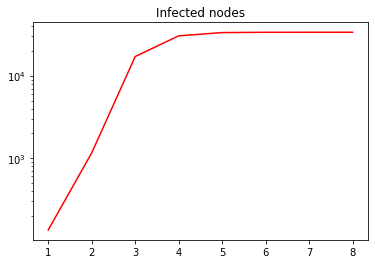

In [25]:
plt.yscale("log")
plt.plot([i for i in range(1,maxHopNoProtection+1)], infectedPerHopNoProtection[1:maxHopNoProtection+1], 'r')
plt.title('Infected nodes')
plt.show()

SCBG

In [26]:
maxHopSCBG , infectedPerHopSCBG , protectedPerHopSCBG = createCurve(nbProtector, Sp, Srumor, g.graph)

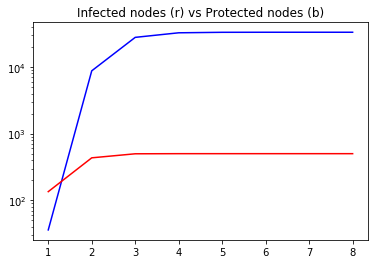

In [27]:
plt.yscale("log")
plt.plot([i for i in range(1,maxHopSCBG+1)], protectedPerHopSCBG[1:maxHopSCBG+1], 'b')
plt.plot([i for i in range(1,maxHopSCBG+1)], infectedPerHopSCBG[1:maxHopSCBG+1], 'r')
plt.title('Infected nodes (r) vs Protected nodes (b)')
plt.show()

Max Degree

In [28]:
maxHopMaxDegree , infectedPerHopMaxDegree , protectedPerHopMaxDegree = createCurve(nbProtector, SpMaxDegree, Srumor, g.graph)

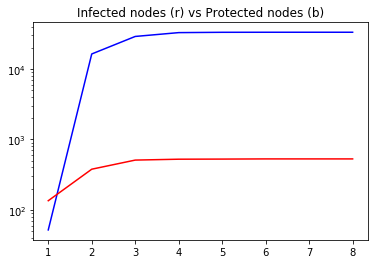

In [29]:
plt.yscale("log")
plt.plot([i for i in range(1,maxHopSCBG+1)], protectedPerHopMaxDegree[1:maxHopSCBG+1], 'b')
plt.plot([i for i in range(1,maxHopSCBG+1)], infectedPerHopMaxDegree[1:maxHopSCBG+1], 'r')
plt.title('Infected nodes (r) vs Protected nodes (b)')
plt.show()

Proximity

In [30]:
maxHopProximity , infectedPerHopProximity , protectedPerHopProximity = createCurve(nbProtector, SpProximity, Srumor, g.graph)

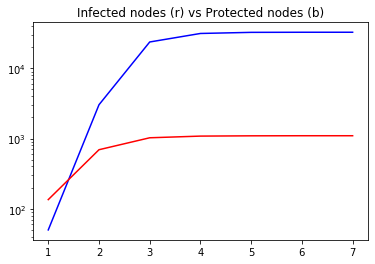

In [31]:
plt.yscale("log")
plt.plot([i for i in range(1,maxHopProximity+1)], protectedPerHopProximity[1:maxHopProximity+1], 'b')
plt.plot([i for i in range(1,maxHopProximity+1)], infectedPerHopProximity[1:maxHopProximity+1], 'r')
plt.title('Infected nodes (r) vs Protected nodes (b)')
plt.show()

##### Compilation

In [32]:
for i in range(20 - len(infectedPerHopSCBG)):
    infectedPerHopSCBG.append(infectedPerHopSCBG[-1])
for i in range(20 - len(infectedPerHopMaxDegree)):
    infectedPerHopMaxDegree.append(infectedPerHopMaxDegree[-1])
for i in range(20 - len(infectedPerHopNoProtection)):
    infectedPerHopNoProtection.append(infectedPerHopNoProtection[-1])
for i in range(20 - len(infectedPerHopProximity)):
    infectedPerHopProximity.append(infectedPerHopProximity[-1])

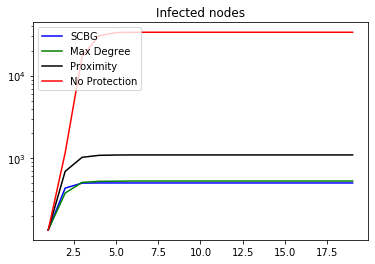

In [33]:
plt.yscale("log")
#plt.plot([i for i in range(1,maxHop+1)], protectedPerHop[:-1], 'b')
l1 = plt.plot([i for i in range(1,20)], infectedPerHopSCBG[1:20], 'b')
l2 = plt.plot([i for i in range(1,20)], infectedPerHopMaxDegree[1:20], 'g')
l3 = plt.plot([i for i in range(1,20)], infectedPerHopProximity[1:20], 'black')
l4 = plt.plot([i for i in range(1,20)], infectedPerHopNoProtection[1:20], 'r')
plt.legend((l1[0], l2[0], l3[0], l4[0]), ('SCBG', 'Max Degree', 'Proximity', 'No Protection'))
plt.title('Infected nodes')
plt.show()